# The analysis for journey data

## An analysis for the cycle hire data

We will consider the influence of multiple factors of the physical environment on the number of travels

In [1]:
# load libraries

import os
import csv
import json
import urllib.request
from requests import get

import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot

import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import linear_model
import statsmodels.api as sm
from scipy.optimize import curve_fit
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant


In [2]:
# set path
points_path = os.path.join('data', 'cycles', 'points')
points_fn = 'BikePoints.geojson'
points_parquet_fn = 'docking_stations.geoparquet'
journeys_path = os.path.join('data', 'cycles', 'journeys')
journeys_gdf_fn = 'journeys_gdf.geoparquet'
journeys_df_fn = 'journeys_df.parquet'
elevation_path = os.path.join('data', 'elevation', 'london_elevation.tif')
geom_path = os.path.join('data', 'London_geometry')
lsoa_fn = 'LSOA_2011_London_gen_MHW.shp'
msoa_fn = 'MSOA_2011_London_gen_MHW.shp'
cc_fn = 'CentralUltraLowEmissionZone.gpkg'

In [3]:
# load data
journeys_gdf = gpd.read_parquet(os.path.join(journeys_path, journeys_gdf_fn))
journeys_df = gpd.read_parquet(os.path.join(journeys_path, journeys_df_fn))

## Basic analysis of the data

First, looking at the characteristics of the dataset.

In [4]:
# filter by start date
journeys_df = journeys_df[journeys_df['Start date'] >= '2022-12-01'].copy()

<Axes: xlabel='Start date,Start date'>

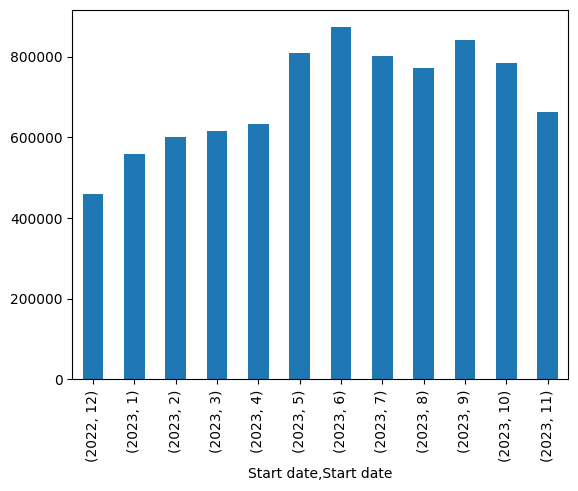

In [5]:
# draw bar chart by month
journeys_df.groupby([journeys_df['Start date'].dt.year, journeys_df['Start date'].dt.month]).Number.count().plot(kind = 'bar')

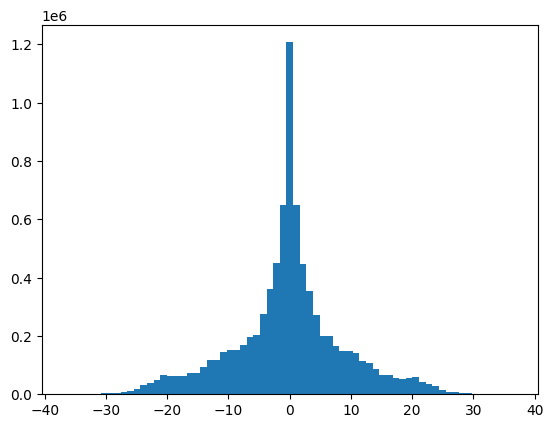

In [6]:
# draw histogram of height distance

# set up plot
fig, ax = plt.subplots(1, 1)

# add histogram
ax.hist(
    journeys_df.height_diff,
    bins = 81
)

# set limits
ax.set_xlim(-40.5, 40.5)

plt.show()


In [7]:
journeys_df[journeys_df['Start station'] != journeys_df['End station']].height_diff.mean()

-0.22877766

In [8]:
scipy.stats.ttest_1samp(journeys_df.height_diff, popmean = 0)

TtestResult(statistic=-69.61426590290411, pvalue=0.0, df=8414630)

### The average height difference

The average of the height difference is -0.22 m. From the one sample T-test, the null hypothesis of average being 0 is rejected, and is statistically significant, concluding that on average the shared cycles are used more downhill than uphill.

(array([1.443276e+06, 2.202603e+06, 1.763172e+06, 1.216677e+06,
        7.556930e+05, 4.513590e+05, 2.545110e+05, 1.445900e+05,
        8.518200e+04, 4.782000e+04, 2.491700e+04, 1.258100e+04,
        6.461000e+03, 2.777000e+03, 1.500000e+03, 9.490000e+02,
        3.900000e+02, 1.320000e+02, 3.600000e+01, 5.000000e+00]),
 array([    0.        ,   858.53878817,  1717.07757635,  2575.61636452,
         3434.15515269,  4292.69394087,  5151.23272904,  6009.77151721,
         6868.31030539,  7726.84909356,  8585.38788173,  9443.92666991,
        10302.46545808, 11161.00424626, 12019.54303443, 12878.0818226 ,
        13736.62061078, 14595.15939895, 15453.69818712, 16312.2369753 ,
        17170.77576347]),
 <BarContainer object of 20 artists>)

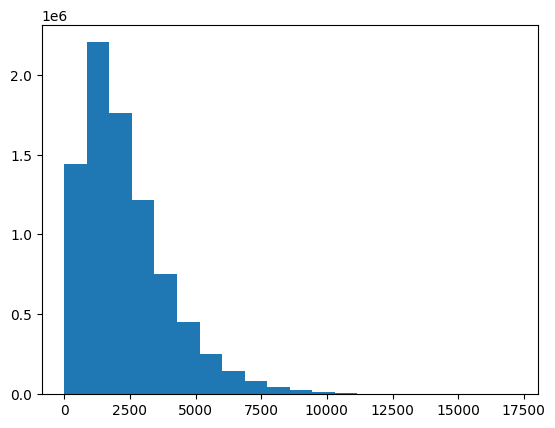

In [9]:
# draw scatter plot


plt.hist(journeys_df['distance'], bins = 20)


In [10]:
# calculate average speed
journeys_df['ave_speed'] = journeys_df['distance'] / journeys_df['Total duration (ms)'] * 1000

### Consider the bike types

The 2 types of bikes existing may make a difference.

In [11]:
journeys_df.head(5)

,Number,Start date,Start station,End date,End station,Bike number,Bike model,Total duration,Total duration (ms),start_id,...,end_LSOA11CD,end_LSOA11NM,end_MSOA11CD,end_MSOA11NM,end_cc_zone,end_geometry,height_diff,distance,geometry,ave_speed
0,127293434,2022-12-04 23:59:00,"Westminster University, Marylebone",2022-12-05 00:08:00,"London Street, Paddington",24140,CLASSIC,9m 5s,545098,001194,...,E01033594,Westminster 015G,E02000974,Westminster 015,False,POINT (526821.250 181157.755),-1.193249,1540.854577,POINT (528105.364 182009.390),2.826748
1,127256557,2022-12-02 20:06:00,"Old Quebec Street, Marylebone",2022-12-02 20:11:00,"London Street, Paddington",51668,CLASSIC,5m 17s,317385,001085,...,E01033594,Westminster 015G,E02000974,Westminster 015,False,POINT (526821.250 181157.755),-0.800749,1073.865608,POINT (527894.602 181124.566),3.383479
2,127222561,2022-12-01 15:48:00,"Old Quebec Street, Marylebone",2022-12-01 15:54:00,"London Street, Paddington",57546,CLASSIC,5m 24s,324227,001085,...,E01033594,Westminster 015G,E02000974,Westminster 015,False,POINT (526821.250 181157.755),-0.800749,1073.865608,POINT (527894.602 181124.566),3.312080
5,127268831,2022-12-03 14:15:00,"Green Park Station, Mayfair",2022-12-03 14:36:00,"London Street, Paddington",14273,CLASSIC,21m 42s,1302999,200096,...,E01033594,Westminster 015G,E02000974,Westminster 015,False,POINT (526821.250 181157.755),7.563251,2342.151738,POINT (528986.985 180265.979),1.797508
6,127268836,2022-12-03 14:15:00,"Green Park Station, Mayfair",2022-12-03 14:36:00,"London Street, Paddington",53406,CLASSIC,21m 35s,1295743,200096,...,E01033594,Westminster 015G,E02000974,Westminster 015,False,POINT (526821.250 181157.755),7.563251,2342.151738,POINT (528986.985 180265.979),1.807574


In [12]:
# compare the height difference
journeys_df.groupby(by = 'Bike model').agg(
    {
        'Number': 'count',
        'distance': 'mean',
        'height_diff': 'mean',
        'ave_speed': 'mean'
    }
)

C:\Users\Soki\AppData\Local\Temp\ipykernel_22072\2799520327.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  journeys_df.groupby(by = 'Bike model').agg(


,Number,distance,height_diff,ave_speed
Bike model,,,,
CLASSIC,7808234,2279.410865,-0.231310,2.658691
PBSC_EBIKE,606397,3124.616509,-0.073767,3.311757


In [13]:
journeys_df.agg(
    {
        'Number': 'count',
        'distance': 'mean',
        'height_diff': 'mean',
        'ave_speed': 'mean'
    }
)

Number         8.414631e+06
distance       2.340320e+03
height_diff   -2.199563e-01
ave_speed      2.705754e+00
dtype: float64

In [14]:
journeys_df.groupby(by = ['Bike model', 'start_cc_zone', 'end_cc_zone']).agg(
    {
        'Number': 'count',
        'height_diff': 'mean',
        'distance': 'mean'
    }
)

C:\Users\Soki\AppData\Local\Temp\ipykernel_22072\3372595322.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  journeys_df.groupby(by = ['Bike model', 'start_cc_zone', 'end_cc_zone']).agg(


Number  height_diff     distance
Bike model start_cc_zone end_cc_zone                                   
CLASSIC    False         False        3544828    -0.177206  1908.713460
                         True         1309928    -0.135193  3235.611315
           True          False        1147155    -0.654645  3229.089534
                         True         1806323    -0.138339  1710.341081
PBSC_EBIKE False         False         243524    -0.124479  2896.378027
                         True          122624     1.010907  3876.993019
           True          False         118822    -1.423388  3931.266267
                         True          121427     0.253238  2033.215035

In [15]:
print(journeys_df[journeys_df.start_id == journeys_df.end_id].shape)
print(journeys_df[journeys_df.start_id != journeys_df.end_id].shape)


(324459, 37)
(8090172, 37)


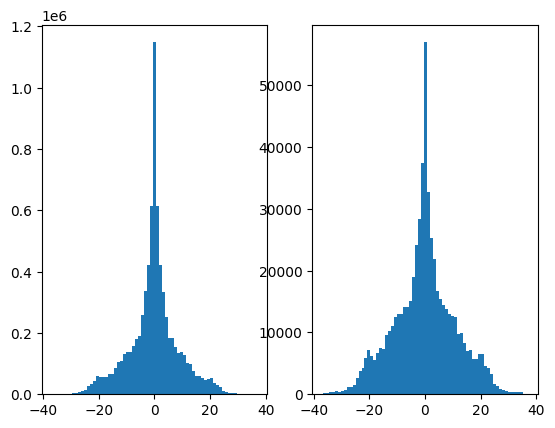

In [16]:
# set up plot
fig, axes = plt.subplots(1, 2)

# add histogram for classic cycles
axes[0].hist(
    journeys_df[journeys_df['Bike model'] == 'CLASSIC'].height_diff,
    bins = 81
)

# add histogram for ebikes
axes[1].hist(
    journeys_df[journeys_df['Bike model'] == 'PBSC_EBIKE'].height_diff,
    bins = 81
)


# set limits
for ax in axes:
    ax.set_xlim(-40.5, 40.5)

plt.show()

In [170]:
# 1 sample t-test

scipy.stats.ttest_1samp(journeys_df[journeys_df['Bike model'] == 'CLASSIC'].height_diff, 0)

TtestResult(statistic=-71.76878311700374, pvalue=0.0, df=7808233)

In [17]:
# conduct t-test

scipy.stats.ttest_ind(
    journeys_df[journeys_df['Bike model'] == 'CLASSIC'].height_diff,
    journeys_df[journeys_df['Bike model'] == 'PBSC_EBIKE'].height_diff
)

# the small p-value indicates there is significant difference in the distributions of the two types of bikes

TtestResult(statistic=-12.893918258674379, pvalue=4.874543134223036e-38, df=8414629.0)

In [74]:
# create dataframe for classic cycles
journeys_classic = journeys_df[journeys_df['Bike model'] == 'CLASSIC'].copy()

## Origin and Destination Analysis

In [18]:
# OD analysis
od_df = journeys_df.groupby(['start_id', 'end_id', 'Bike model']).Number.count().reset_index()

C:\Users\Soki\AppData\Local\Temp\ipykernel_22072\218624464.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  od_df = journeys_df.groupby(['start_id', 'end_id', 'Bike model']).Number.count().reset_index()


### Prepare Points Data

In [215]:
# join with bike points data

# read points data
points_gdf = gpd.read_parquet(os.path.join(points_path, points_parquet_fn)).set_index('id')

# make ports into numeric
points_gdf['ports'] = points_gdf.ports.astype('int')

# make cc_zone into numeric
points_gdf['cc_zone'] = points_gdf['cc_zone'].astype('int')


In [241]:
sum(points_gdf.height < 20) / points_gdf.shape[0]

0.76875

#### Join with transport data

TfL defined PTAL data

<Axes: >

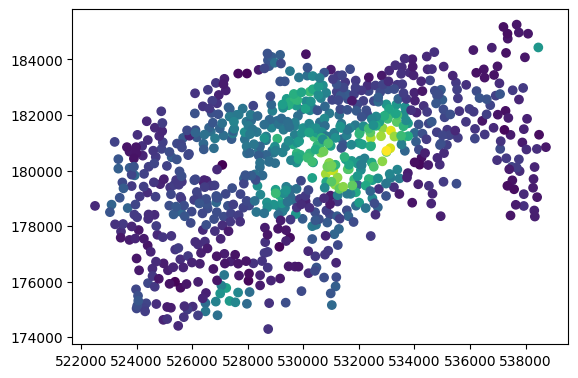

In [216]:
# join with PTAL grid value

# get file path
ptal_path = os.path.join('data', '2015  PTALs Grid Values')
ptal_fn = '2015  PTALs Grid Values 280515.xlsx'

# read from excel file
# source: London Data Store
# https://data.london.gov.uk/dataset/public-transport-accessibility-levels
ptal_df = pd.read_excel(os.path.join(ptal_path, ptal_fn), sheet_name = 0).drop(columns = 'ID')

# get GeoDataFrame

ptal_gdf = gpd.GeoDataFrame(ptal_df.AI2015, geometry = gpd.points_from_xy(ptal_df.X, ptal_df.Y), crs = 'EPSG:27700')

# get access index value for each docking station
points_gdf['ptal_id'] = ptal_gdf.sindex.nearest(points_gdf.geometry, return_all = False)[1]
points_gdf = points_gdf.join(ptal_gdf.AI2015, on = 'ptal_id')

# plot AI for points
points_gdf.plot(c = points_gdf.AI2015)

### Load MSOA data

MSOA data is loaded and joined here

In [217]:
# load geometry
msoa_geom = gpd.read_file(os.path.join(geom_path, msoa_fn)).set_index('MSOA11CD')

# join population data
# year: 2020
# source: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/middlesuperoutputareamidyearpopulationestimates
msoa_pop = pd.read_csv(os.path.join('data', 'msoa_population.csv'), skiprows = 4)
msoa_pop = msoa_pop[['MSOA Code', 'All Ages']].copy().rename(columns = {'All Ages': 'population'}).set_index('MSOA Code')

# change population into integer
msoa_pop['population'] = msoa_pop['population'].str.replace(',','').astype('int')

# calculate area in m2
msoa_geom['msoa_area'] = msoa_geom.area

# join with population
msoa_gdf = msoa_geom.join(msoa_pop, how = 'inner')

# calculate population density
msoa_gdf['pop_density'] = msoa_gdf.population / msoa_gdf.msoa_area


### Usage analysis

#### individual stations

##### summary statistics

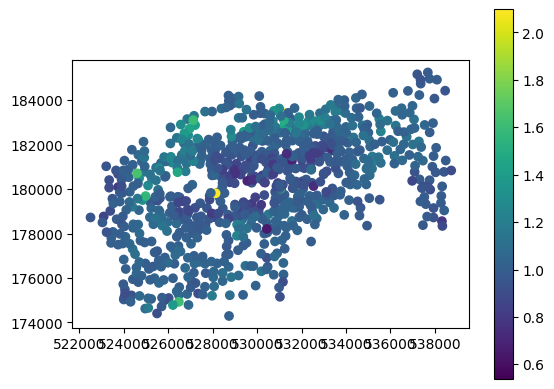

In [218]:
# summarise by ID
dep_df = journeys_classic.groupby('start_id').agg({'Number': 'count'}).rename(columns = {'Number': 'dep'})
arr_df = journeys_classic.groupby('end_id').agg({'Number': 'count'}).rename(columns = {'Number': 'arr'})

# join to the GDF
usage_gdf = points_gdf.join(dep_df.join(arr_df))

# create column for ratio
usage_gdf['od_ratio'] = usage_gdf.dep / usage_gdf.arr

# make plot
usage_gdf.plot(column = 'od_ratio', legend = True)

plt.show()

In [219]:
# join with MSOA data
usage_gdf = usage_gdf.join(msoa_gdf[['population', 'pop_density']].add_prefix('MSOA_'), on = 'MSOA11CD')

##### Dep / Arr Ratio

In [220]:
# do the linear regression
slope, intercept, r, p, std_error = scipy.stats.linregress(usage_gdf.height, usage_gdf.od_ratio)

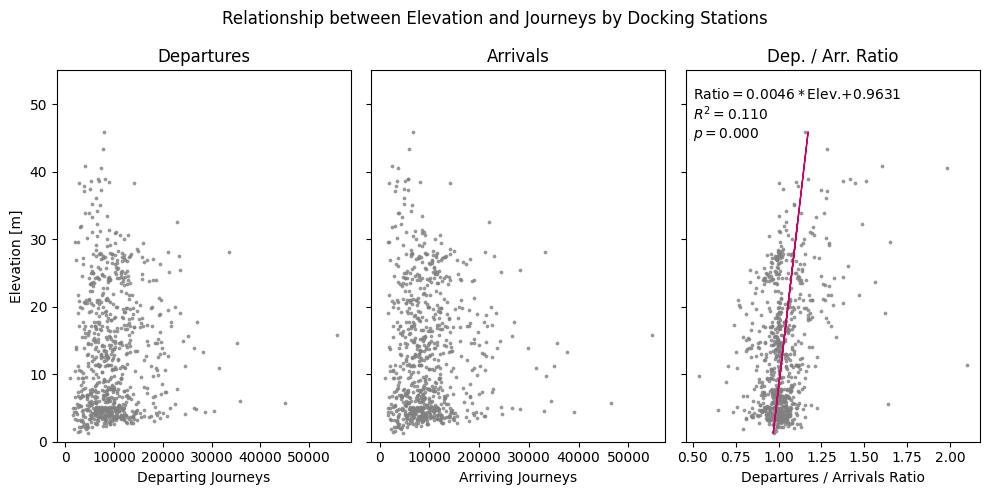

In [221]:
# scatter plot

# make plot

fig, axes = plt.subplots(1,3, figsize = (10, 5), sharey = True)

dot_color = 'gray'

# departures
axes[0].scatter(
    x = usage_gdf.dep,
    y = usage_gdf.height,
    s = 3,
    c = dot_color,
    alpha = 0.7
)

# arrivals
axes[1].scatter(
    x = usage_gdf.arr,
    y = usage_gdf.height,
    s = 3,
    c = dot_color,
    alpha = 0.7    
)

# ratio
axes[2].scatter(
    x = usage_gdf.od_ratio,
    y = usage_gdf.height,
    s = 3,
    c = dot_color,
    alpha = 0.7
)

# set limits
axes[0].set_ylim(0, 55)

# add regression line
axes[2].plot(usage_gdf.height * slope + intercept, usage_gdf.height, color = 'xkcd:deep pink', linewidth = 1)
# annotate R squared value
axes[2].annotate(f'Ratio$= {slope:.4f} * $Elev.$ + {intercept:.4f} $\n$R^2={r ** 2:.3f}$\n$p = {p:.3f}$', xy = (0.5, 45))

# set labels
axes[0].set_ylabel('Elevation [m]')
axes[0].set_xlabel('Departing Journeys')
axes[0].set_title('Departures')
axes[1].set_xlabel('Arriving Journeys')
axes[1].set_title('Arrivals')
axes[2].set_xlabel('Departures / Arrivals Ratio')
axes[2].set_title('Dep. / Arr. Ratio')
plt.suptitle('Relationship between Elevation and Journeys by Docking Stations')

plt.tight_layout()
plt.show()


In [222]:
usage_gdf

,name,ports,location,zone,height,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,cc_zone,geometry,ptal_id,AI2015,dep,arr,od_ratio,MSOA_population,MSOA_pop_density
id,,,,,,,,,,,,,,,,,,
001023,"River Street , Clerkenwell",19,River Street,Clerkenwell,32.264999,E01002729,Islington 021E,E02000574,Islington 021,1,POINT (531203.555 182832.015),92490,29.654423,6509,4385,1.484379,10084,0.016597
003470,"Great Percy Street, Clerkenwell",23,Great Percy Street,Clerkenwell,16.019001,E01002729,Islington 021E,E02000574,Islington 021,1,POINT (530822.081 182794.578),91969,67.521452,6732,5863,1.148218,10084,0.016597
001018,"Phillimore Gardens, Kensington",37,Phillimore Gardens,Kensington,11.532250,E01002865,Kensington and Chelsea 011E,E02000587,Kensington and Chelsea 011,0,POINT (525208.086 179391.817),74873,22.981596,12597,13309,0.946502,7627,0.014608
003463,"Argyll Road, Kensington",19,Argyll Road,Kensington,12.497499,E01002865,Kensington and Chelsea 011E,E02000587,Kensington and Chelsea 011,0,POINT (525352.982 179483.848),75358,28.100911,6359,6463,0.983908,7627,0.014608
001012,"Christopher Street, Liverpool Street",32,Christopher Street,Liverpool Street,16.526251,E01033708,Hackney 027G,E02000371,Hackney 027,1,POINT (532985.858 182001.488),87905,94.943031,7368,8762,0.840904,16909,0.016965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300061,"Crimscott Street, Bermondsey",19,Crimscott Street,Bermondsey,3.232750,E01003979,Southwark 006E,E02000812,Southwark 006,0,POINT (533457.096 179155.634),73987,10.488218,8160,7585,1.075808,10762,0.015254
300060,"Brandon Street, Walworth",22,Brandon Street,Walworth,3.697000,E01003963,Southwark 016A,E02000822,Southwark 016,0,POINT (532597.510 178410.283),70569,19.494520,6881,6784,1.014298,7061,0.014955
300059,"The Blue, Bermondsey",22,The Blue,Bermondsey,1.810750,E01004042,Southwark 010D,E02000816,Southwark 010,0,POINT (534604.014 178810.071),72544,15.702846,4169,4254,0.980019,10725,0.014104


##### linear regression

In [ ]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568


def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df


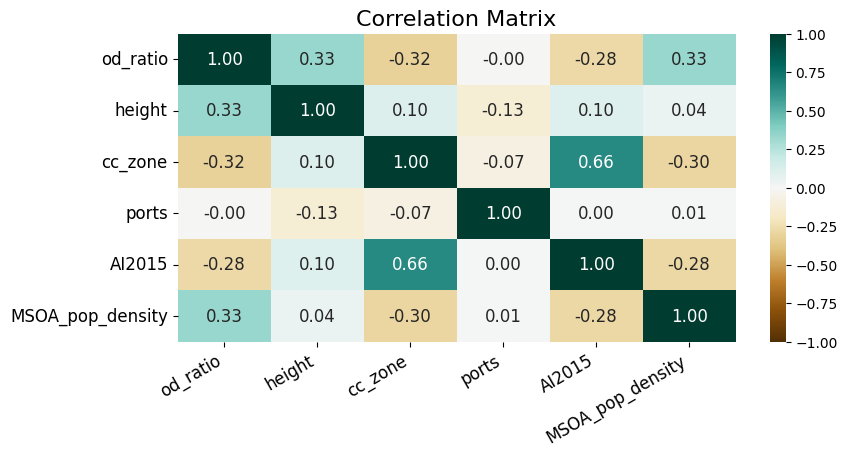

The columns remaining after VIF selection are:
Index(['height', 'cc_zone', 'ports', 'AI2015', 'MSOA_pop_density'], dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               od_ratio   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     64.89
Date:                Sat, 13 Jan 2024   Prob (F-statistic):           7.93e-57
Time:                        15:45:45   Log-Likelihood:                 658.78
No. Observations:                 800   AIC:                            -1306.
Df Residuals:                     794   BIC:                            -1277.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.9246      0.018     52.034      0.000       0.890       0.959
height               0.0049      0.000     11.783      0.000       0.004       0.006
cc_zone             -0.0567      0.011     -5.268      0.000      -0.078      -0.036
ports                0.0003      0.000      0.794      0.427      -0.001       0.001
AI2015              -0.0005      0.000     -2.757      0.006      -0.001      -0.000
MSOA_pop_density     4.6302      0.660      7.011      0.000       3.334       5.927
==============================================================================
Omnibus:                      592.976   Durbin-Watson:                   1.547
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18348.907
Skew:                           2.980   Prob(JB):                         0.00
Kurtosis:                      25.692   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [228]:
# set dependent variables
columns  = ['od_ratio', 'height', 'cc_zone', 'ports', 'AI2015', 'MSOA_pop_density']

# set model
x = usage_gdf[columns]
y = usage_gdf.od_ratio

# check multicollinearity
plt.figure(figsize = (9, 4))
heatmap = sns.heatmap(usage_gdf[columns].corr(), annot = True, vmin = -1, vmax = 1, cmap = 'BrBG', fmt = '.2f', annot_kws = {'fontsize': 12})
# plt.rcParams["axes.grid"] = False
# f = plt.figure(figsize=(10, 8))
# plt.matshow(df.corr(), fignum=f.number, cmap = 'Blues')
plt.xticks(fontsize = 12, rotation=30, ha = 'right') # rotation of xticks
plt.yticks(fontsize = 12)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

# show plot
plt.show()


# using VIF on the dataset
df_predictors_selected_VIF = drop_column_using_vif_(x.drop('od_ratio', axis=1))

# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

# run regression model
model_ports = sm.OLS(endog = y, exog = sm.add_constant(df_predictors_selected_VIF)).fit()
model_ports.summary()

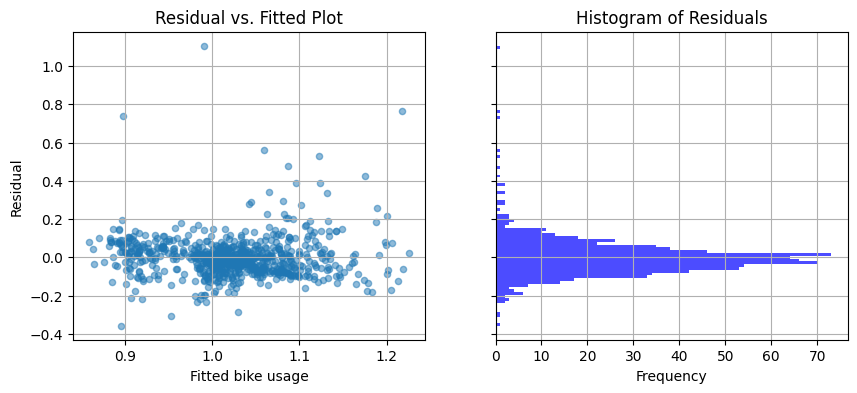

In [229]:
# plot the figures for justification

# creat subplot
f, axes = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

# Residuals vs. Fitted plot

# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
axes[0].scatter(model_ports.fittedvalues, model_ports.resid, alpha = 0.5, s=20)
# plt.scatter(model1.fittedvalues, model1.resid, alpha = 0.5)
# adding title and labels
axes[0].set_xlabel('Fitted bike usage')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residual vs. Fitted Plot')
# Adding grid lines
axes[0].grid(True)

# Histogram of residuals

# Plotting the histogram
axes[1].hist(model_ports.resid, bins=100, color='blue', edgecolor=None, alpha=0.7, orientation = 'horizontal')

# Adding labels and title
axes[1].set_xlabel('Frequency')
# axes[1].set_ylabel('Residuals')
axes[1].set_title('Histogram of Residuals')

# Adding grid lines (optional)
axes[1].grid(True)

# Display the plot
plt.show()


#### Summarise by MSOA



<Axes: >

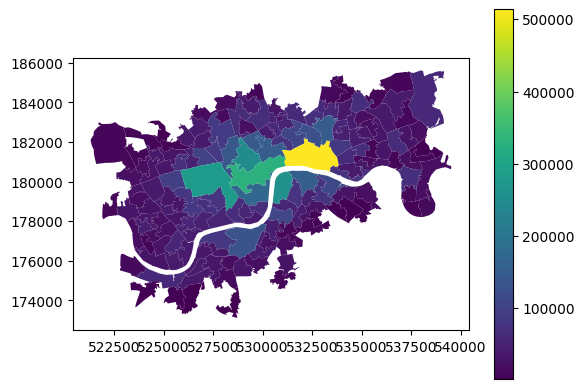

In [21]:
# summarise by MSOA
dep_df = journeys_df.groupby('start_MSOA11CD').agg({'Number': 'count', 'start_id': 'nunique'}).rename(columns = {'Number': 'dep', 'start_id': 'ports'})
arr_df = journeys_df.groupby('end_MSOA11CD').agg({'Number': 'count'}).rename(columns = {'Number': 'arr'})

# join to the GDF
msoa_usage_gdf = msoa_geom.join(dep_df.join(arr_df))

# make plot
msoa_usage_gdf.plot(column = 'dep', legend = True)

### Transport accessibility

TfL defined PTAL is considered

In [26]:
# join OD data with points
od_df = od_df.join(points_gdf.add_prefix('start_'), on = 'start_id').join(points_gdf.add_prefix('end_'), on = 'end_id')

In [27]:
# convert number of ports into numeric
numbers = ['start_ports', 'end_ports']
for c in numbers:
    od_df[c] = od_df[c].astype('int')

In [28]:
# define start and end points as GeoSeries
start_geoseries = gpd.GeoSeries(od_df.start_geometry, crs = 'EPSG:27700')
end_geoseries = gpd.GeoSeries(od_df.end_geometry, crs = 'EPSG:27700')

# calculate distance and store in df
od_df['distance'] = start_geoseries.distance(end_geoseries, align = False)

# calculate height difference and store in df
od_df['height_diff'] = od_df.end_height - od_df.start_height

In [30]:
# group by MSOA
msoa_od = od_df[od_df['Bike model'] == 'CLASSIC'].groupby(['start_MSOA11CD', 'end_MSOA11CD']).agg(
    {
        'Number': 'sum',
        'distance': 'mean',
        'height_diff': 'mean',
    }
).reset_index()

# summarise the point information by MSOA as well
points_msoa = points_gdf.groupby('MSOA11CD').agg(
    {
        'name': 'count',
        'ports': 'sum',
        'height': 'mean',
        'AI2015': 'mean',
        'cc_zone': 'mean'
    }
).rename(columns = {'name': 'stations', 'ports': 'total_ports', 'height': 'mean_height'})



In [31]:
# join with summarised point information
msoa_od = msoa_od.join(points_msoa.add_prefix('start_'), on = 'start_MSOA11CD').join(points_msoa.add_prefix('end_'), on = 'end_MSOA11CD')

# calculate journeys per station
msoa_od['number_per_stn'] = msoa_od.Number / msoa_od.start_stations / msoa_od.end_stations

In [32]:
# join population data
# year: 2020
# source: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/middlesuperoutputareamidyearpopulationestimates

msoa_pop = pd.read_csv(os.path.join('data', 'msoa_population.csv'), skiprows = 4)
msoa_pop = msoa_pop[['MSOA Code', 'All Ages']].copy().rename(columns = {'All Ages': 'population'}).set_index('MSOA Code')

# change population into integer
msoa_pop['population'] = msoa_pop['population'].str.replace(',','').astype('int')

# calculate area in km2
msoa_geom['msoa_area'] = msoa_geom.area / 1000000

# join with population
msoa_pop = msoa_pop.join(msoa_geom['msoa_area'], how = 'inner')

# calculate population density
msoa_pop['pop_density'] = msoa_pop.population / msoa_pop.msoa_area


In [35]:
msoa_od = msoa_od.join(msoa_pop.add_prefix('start_'), on = 'start_MSOA11CD').join(msoa_pop.add_prefix('end_'), on = 'end_MSOA11CD')

<Axes: xlabel='Start date'>

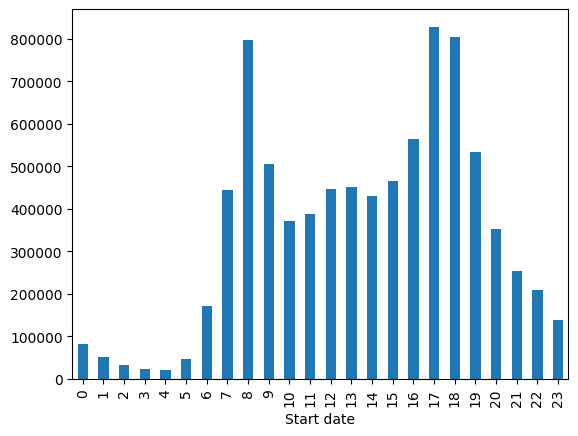

In [36]:
journeys_df.groupby(journeys_df['Start date'].dt.hour).Number.count().plot(kind = 'bar')

In [37]:
points_gdf

,name,ports,location,zone,height,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,cc_zone,geometry,ptal_id,AI2015
id,,,,,,,,,,,,,
001023,"River Street , Clerkenwell",19,River Street,Clerkenwell,32.264999,E01002729,Islington 021E,E02000574,Islington 021,1,POINT (531203.555 182832.015),92490,29.654423
003470,"Great Percy Street, Clerkenwell",23,Great Percy Street,Clerkenwell,16.019001,E01002729,Islington 021E,E02000574,Islington 021,1,POINT (530822.081 182794.578),91969,67.521452
001018,"Phillimore Gardens, Kensington",37,Phillimore Gardens,Kensington,11.532250,E01002865,Kensington and Chelsea 011E,E02000587,Kensington and Chelsea 011,0,POINT (525208.086 179391.817),74873,22.981596
003463,"Argyll Road, Kensington",19,Argyll Road,Kensington,12.497499,E01002865,Kensington and Chelsea 011E,E02000587,Kensington and Chelsea 011,0,POINT (525352.982 179483.848),75358,28.100911
001012,"Christopher Street, Liverpool Street",32,Christopher Street,Liverpool Street,16.526251,E01033708,Hackney 027G,E02000371,Hackney 027,1,POINT (532985.858 182001.488),87905,94.943031
...,...,...,...,...,...,...,...,...,...,...,...,...,...
300061,"Crimscott Street, Bermondsey",19,Crimscott Street,Bermondsey,3.232750,E01003979,Southwark 006E,E02000812,Southwark 006,0,POINT (533457.096 179155.634),73987,10.488218
300060,"Brandon Street, Walworth",22,Brandon Street,Walworth,3.697000,E01003963,Southwark 016A,E02000822,Southwark 016,0,POINT (532597.510 178410.283),70569,19.494520
300059,"The Blue, Bermondsey",22,The Blue,Bermondsey,1.810750,E01004042,Southwark 010D,E02000816,Southwark 010,0,POINT (534604.014 178810.071),72544,15.702846


## Subsetting the data

An analysis of the whole picture is difficult to comprehend at the beginning, so a dataset using

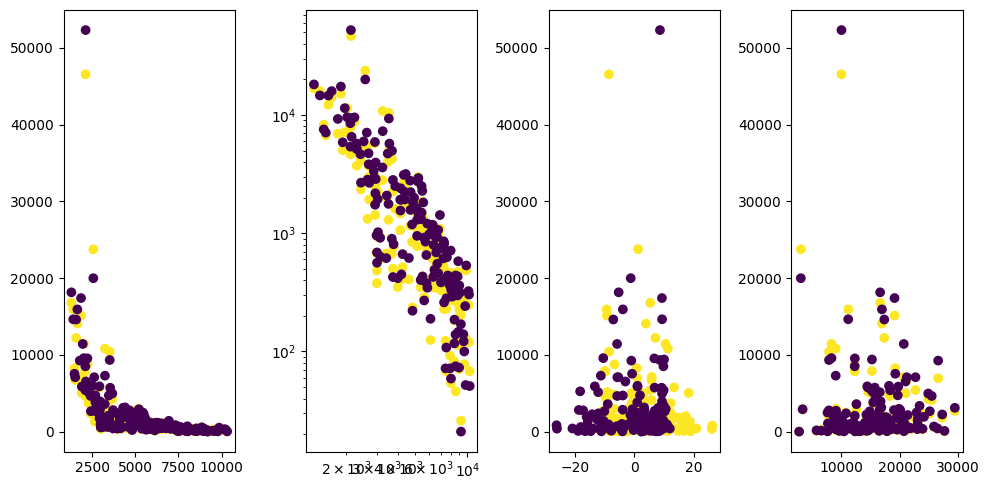

In [38]:
# extract one origin or destination to begin
# chose the City of London as starting point for analysis

#target_msoa = 'E02000001'
target_msoa = 'E02000001'


city_df = msoa_od[((msoa_od.start_MSOA11CD == target_msoa) | (msoa_od.end_MSOA11CD == target_msoa)) & (msoa_od.start_MSOA11CD != msoa_od.end_MSOA11CD)].copy()
# create columns containing data for the 'other' area

#city_df['other_stations'] = []
#city_df['other_total_ports'] = []
#city_df['other_mean_height'] = []
#city_df['is_outbound'] = []

for idx, row in city_df.iterrows():
    if(row['start_MSOA11CD'] == target_msoa):
        city_df.loc[idx, 'other_stations'] = row['end_stations']
        city_df.loc[idx, 'other_total_ports'] = row['end_total_ports']
        city_df.loc[idx, 'other_mean_height'] = row['end_mean_height']
        city_df.loc[idx, 'other_AI2015'] = row['end_AI2015']
        city_df.loc[idx, 'other_pop'] = row['end_pop_density']
        city_df.loc[idx, 'is_outbound'] = 1
    else:
        city_df.loc[idx, 'other_stations'] = row['start_stations']
        city_df.loc[idx, 'other_total_ports'] = row['start_total_ports']
        city_df.loc[idx, 'other_mean_height'] = row['start_mean_height']
        city_df.loc[idx, 'other_AI2015'] = row['start_AI2015']   
        city_df.loc[idx, 'other_pop'] = row['start_pop_density']     
        city_df.loc[idx, 'is_outbound'] = 0      

# make plot
fig, axes = plt.subplots(1,4, figsize = (10, 5))

# distance
axes[0].scatter(
    x = city_df.distance,
    y = city_df.Number,
    c = city_df.is_outbound
)

axes[1].scatter(
    x = city_df.distance,
    y = city_df.Number,
    c = city_df.is_outbound
)


# take a double log scale for the second one
axes[1].set_xscale('log')
axes[1].set_yscale('log')

# height difference
axes[2].scatter(
    x = city_df.height_diff,
    y = city_df.Number,
    c = city_df.is_outbound
)

# total ports
axes[3].scatter(
    x = city_df.other_pop,
    y = city_df.Number,
    c = city_df.is_outbound
)

plt.tight_layout()
plt.show()

In [39]:
# check the power law behind distance

city_df2 = city_df[city_df.Number != 0].copy()

# get log for distance and trips
city_df2['distance_log'] = np.log(city_df2.distance)
city_df2['number_log'] = np.log(city_df2.Number)

log_model = sm.OLS(endog = city_df2['number_log'], exog = sm.add_constant(city_df2['distance_log'])).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             number_log   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     783.4
Date:                Sat, 13 Jan 2024   Prob (F-statistic):           1.49e-87
Time:                        11:34:47   Log-Likelihood:                -365.62
No. Observations:                 318   AIC:                             735.2
Df Residuals:                     316   BIC:                             742.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           26.4892      0.700     37.841      0.000      25.112      27.866
distance_log    -2.3132      0.083    -27.989      0.000      -2.476      -2.151
==============================================================================
Omnibus:                        7.908   Durbin-Watson:                   1.419
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                7.969
Skew:                          -0.387   Prob(JB):                       0.0186
Kurtosis:                       3.045   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Correlation Matrix')

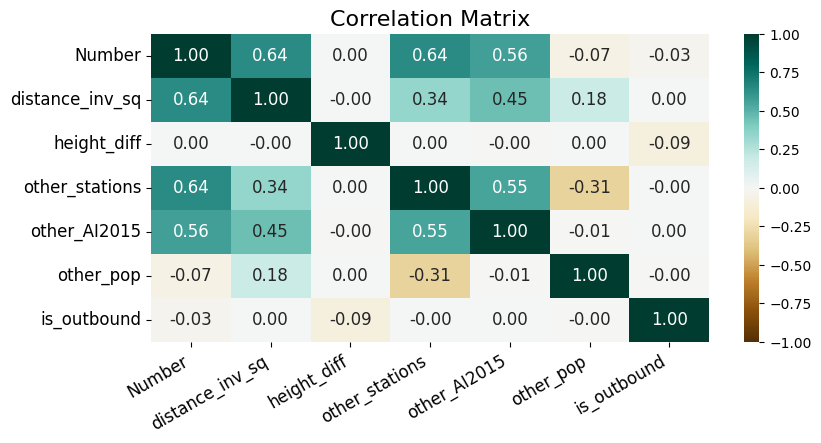

In [40]:
# calculate inverse squared value
city_df['distance_inv_sq'] = city_df.distance.astype('float') ** (-2) * 1000000

# check multi-colinearity
reg_df = city_df[['Number', 'distance_inv_sq', 'height_diff', 'other_stations', 'other_AI2015', 'other_pop', 'is_outbound']].copy()
plt.figure(figsize = (9, 4))
heatmap = sns.heatmap(reg_df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'BrBG', fmt = '.2f', annot_kws = {'fontsize': 12})
# plt.rcParams["axes.grid"] = False
# f = plt.figure(figsize=(10, 8))
# plt.matshow(df.corr(), fignum=f.number, cmap = 'Blues')
plt.xticks(fontsize = 12, rotation=30, ha = 'right') # rotation of xticks
plt.yticks(fontsize = 12)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [41]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568


def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

# using VIF on the dataset
df_predictors_selected_VIF = drop_column_using_vif_(reg_df.drop('Number', axis=1))

# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

The columns remaining after VIF selection are:
Index(['distance_inv_sq', 'height_diff', 'other_stations', 'other_AI2015',
       'other_pop', 'is_outbound'],
      dtype='object')


In [42]:
# run linear regression

# set dependent variables
#x = city_df[['distance_inv_sq', 'height_diff', 'other_stations', 'other_pop', 'is_outbound']]
x = df_predictors_selected_VIF
y = city_df.Number

model1 = sm.OLS(endog = y, exog = sm.add_constant(x)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Number   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     88.47
Date:                Sat, 13 Jan 2024   Prob (F-statistic):           2.79e-64
Time:                        11:34:48   Log-Likelihood:                -3015.6
No. Observations:                 318   AIC:                             6045.
Df Residuals:                     311   BIC:                             6072.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -2422.6827    745.016     -3.252      0.001   -3888.592    -956.773
distance_inv_sq  2.313e+04   2094.249     11.044      0.000     1.9e+04    2.72e+04
height_diff         0.7890     20.102      0.039      0.969     -38.765      40.343
other_stations    542.9293     60.293      9.005      0.000     424.295     661.563
other_AI2015       35.3196     11.515      3.067      0.002      12.663      57.976
other_pop          -0.0210      0.039     -0.546      0.586      -0.097       0.055
is_outbound      -291.4769    361.979     -0.805      0.421   -1003.714     420.761
==============================================================================
Omnibus:                      465.139   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            79830.060
Skew:                           7.236   Prob(JB):                         0.00
Kurtosis:                      79.259   Cond. No.                     1.92e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

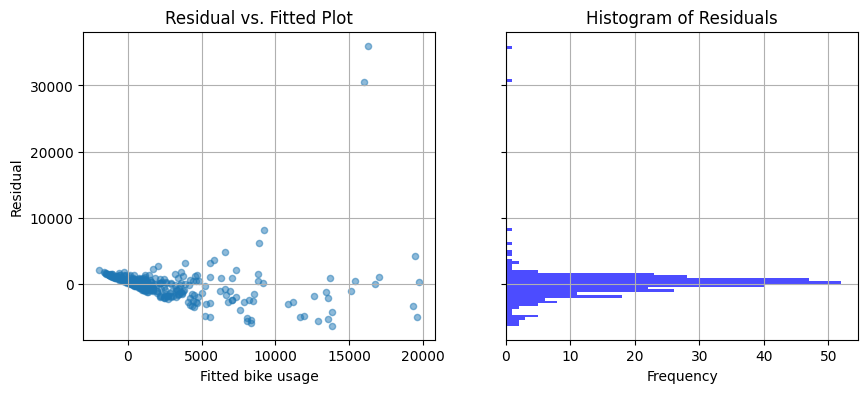

In [43]:
# plot the figures for justification

# creat subplot
f, axes = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

# Residuals vs. Fitted plot

# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
axes[0].scatter(model1.fittedvalues, model1.resid, alpha = 0.5, s=20)
# plt.scatter(model1.fittedvalues, model1.resid, alpha = 0.5)
# adding title and labels
axes[0].set_xlabel('Fitted bike usage')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residual vs. Fitted Plot')
# Adding grid lines
axes[0].grid(True)

# Histogram of residuals

# Plotting the histogram
axes[1].hist(model1.resid, bins=100, color='blue', edgecolor=None, alpha=0.7, orientation = 'horizontal')

# Adding labels and title
axes[1].set_xlabel('Frequency')
# axes[1].set_ylabel('Residuals')
axes[1].set_title('Histogram of Residuals')

# Adding grid lines (optional)
axes[1].grid(True)

# Display the plot
plt.show()


Text(0.5, 1.0, 'Correlation Matrix')

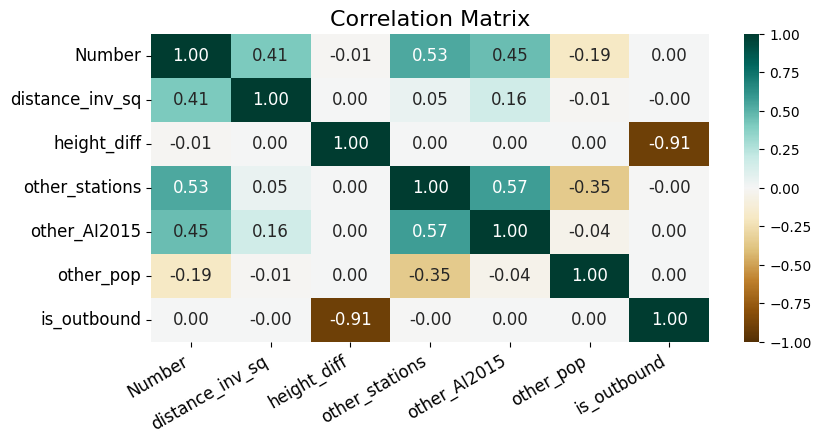

In [44]:
# extract one origin or destination to begin
# chose Primrose Hill as starting point for analysis

target_msoa = 'E02000183'


city_df = msoa_od[((msoa_od.start_MSOA11CD == target_msoa) | (msoa_od.end_MSOA11CD == target_msoa)) & (msoa_od.start_MSOA11CD != msoa_od.end_MSOA11CD)].copy()
# create columns containing data for the 'other' area

#city_df['other_stations'] = []
#city_df['other_total_ports'] = []
#city_df['other_mean_height'] = []
#city_df['is_outbound'] = []

for idx, row in city_df.iterrows():
    if(row['start_MSOA11CD'] == target_msoa):
        city_df.loc[idx, 'other_stations'] = row['end_stations']
        city_df.loc[idx, 'other_total_ports'] = row['end_total_ports']
        city_df.loc[idx, 'other_mean_height'] = row['end_mean_height']
        city_df.loc[idx, 'other_AI2015'] = row['end_AI2015']
        city_df.loc[idx, 'other_pop'] = row['end_pop_density']
        city_df.loc[idx, 'is_outbound'] = 1
    else:
        city_df.loc[idx, 'other_stations'] = row['start_stations']
        city_df.loc[idx, 'other_total_ports'] = row['start_total_ports']
        city_df.loc[idx, 'other_mean_height'] = row['start_mean_height']
        city_df.loc[idx, 'other_AI2015'] = row['start_AI2015']   
        city_df.loc[idx, 'other_pop'] = row['start_pop_density']     
        city_df.loc[idx, 'is_outbound'] = 0 

# calculate inverse squared value
city_df['distance_inv_sq'] = city_df.distance.astype('float') ** (-2) * 1000000

# check multi-colinearity
reg_df = city_df[['Number', 'distance_inv_sq', 'height_diff', 'other_stations', 'other_AI2015', 'other_pop', 'is_outbound']].copy()
plt.figure(figsize = (9, 4))
heatmap = sns.heatmap(reg_df.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'BrBG', fmt = '.2f', annot_kws = {'fontsize': 12})
# plt.rcParams["axes.grid"] = False
# f = plt.figure(figsize=(10, 8))
# plt.matshow(df.corr(), fignum=f.number, cmap = 'Blues')
plt.xticks(fontsize = 12, rotation=30, ha = 'right') # rotation of xticks
plt.yticks(fontsize = 12)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [45]:
points_msoa.sort_values('mean_height', ascending = False).head(30)

,stations,total_ports,mean_height,AI2015,cc_zone
MSOA11CD,,,,,
E02000962,6,164,39.190136,21.809507,0.000
E02000960,3,74,39.055500,8.905895,0.000
E02000968,6,123,33.874710,41.734373,0.000
E02000964,1,18,31.953327,24.019019,0.000
E02000572,5,149,31.723049,34.100081,0.000
E02000573,4,90,31.284126,29.338710,0.000
E02000180,1,24,31.257751,7.170528,0.000
E02000183,2,53,31.088625,35.816240,0.000
E02000967,8,156,30.294876,47.302148,0.250


In [46]:
# check the power law behind distance

city_df2 = city_df[city_df.Number != 0].copy()

# get log for distance and trips
city_df2['distance_log'] = np.log(city_df2.distance)
city_df2['number_log'] = np.log(city_df2.Number)

log_model = sm.OLS(endog = city_df2['number_log'], exog = sm.add_constant(city_df2['distance_log'])).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             number_log   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     596.1
Date:                Sat, 13 Jan 2024   Prob (F-statistic):           1.25e-73
Time:                        11:34:50   Log-Likelihood:                -442.02
No. Observations:                 306   AIC:                             888.0
Df Residuals:                     304   BIC:                             895.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           28.3356      1.036     27.362      0.000      26.298      30.373
distance_log    -2.9241      0.120    -24.415      0.000      -3.160      -2.688
==============================================================================
Omnibus:                        2.036   Durbin-Watson:                   1.702
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.762
Skew:                          -0.170   Prob(JB):                        0.414
Kurtosis:                       3.150   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
# using VIF on the dataset
df_predictors_selected_VIF = drop_column_using_vif_(reg_df.drop(['Number', 'is_outbound'], axis=1))

# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_predictors_selected_VIF.columns)

The columns remaining after VIF selection are:
Index(['distance_inv_sq', 'height_diff', 'other_stations', 'other_AI2015',
       'other_pop'],
      dtype='object')


In [48]:
# run linear regression

# set dependent variables
#x = city_df[['distance_inv_sq', 'height_diff', 'other_stations', 'other_pop', 'is_outbound']]
x = df_predictors_selected_VIF
y = city_df.Number

model1 = sm.OLS(endog = y, exog = sm.add_constant(x)).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Number   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     50.83
Date:                Sat, 13 Jan 2024   Prob (F-statistic):           1.94e-38
Time:                        11:34:50   Log-Likelihood:                -2124.5
No. Observations:                 318   AIC:                             4261.
Df Residuals:                     312   BIC:                             4284.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -76.7718     42.219     -1.818      0.070    -159.841       6.298
distance_inv_sq   425.2467     49.771      8.544      0.000     327.318     523.176
height_diff        -0.1126      0.523     -0.215      0.830      -1.141       0.916
other_stations     22.6144      3.068      7.371      0.000      16.578      28.651
other_AI2015        2.0001      0.671      2.983      0.003       0.681       3.319
other_pop          -0.0017      0.002     -0.760      0.448      -0.006       0.003
==============================================================================
Omnibus:                      296.879   Durbin-Watson:                   1.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8607.667
Skew:                           3.818   Prob(JB):                         0.00
Kurtosis:                      27.317   Cond. No.                     7.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

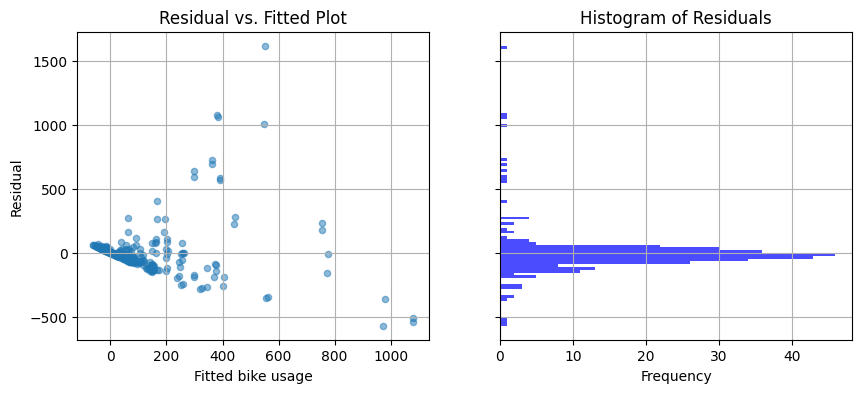

In [49]:
# plot the figures for justification

# creat subplot
f, axes = plt.subplots(1, 2, figsize = (10, 4), sharey = True)

# Residuals vs. Fitted plot

# alpha = 0.5: controlling the transparency of the markers. Here alpha = 0.5 means that the markers are semi-transparent.
# s = 20: controlling the size of the markers. The default value is plt.rcParams['lines.markersize'] ** 2. Here we set it as 20.
# To get the default value of marker size, run the following line
# print(plt.rcParams['lines.markersize'] ** 2) 
axes[0].scatter(model1.fittedvalues, model1.resid, alpha = 0.5, s=20)
# plt.scatter(model1.fittedvalues, model1.resid, alpha = 0.5)
# adding title and labels
axes[0].set_xlabel('Fitted bike usage')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residual vs. Fitted Plot')
# Adding grid lines
axes[0].grid(True)

# Histogram of residuals

# Plotting the histogram
axes[1].hist(model1.resid, bins=100, color='blue', edgecolor=None, alpha=0.7, orientation = 'horizontal')

# Adding labels and title
axes[1].set_xlabel('Frequency')
# axes[1].set_ylabel('Residuals')
axes[1].set_title('Histogram of Residuals')

# Adding grid lines (optional)
axes[1].grid(True)

# Display the plot
plt.show()


In [50]:
msoa_od

,start_MSOA11CD,end_MSOA11CD,Number,distance,height_diff,start_stations,start_total_ports,start_mean_height,start_AI2015,start_cc_zone,...,end_mean_height,end_AI2015,end_cc_zone,number_per_stn,start_population,start_msoa_area,start_pop_density,end_population,end_msoa_area,end_pop_density
0,E02000001,E02000001,63321,972.288501,-2.641757e-09,38,1008,13.108163,90.035485,1.0,...,13.108163,90.035485,1.0,43.851108,10938,2.905399,3764.714879,10938,2.905399,3764.714879
1,E02000001,E02000180,502,3715.141455,1.814959e+01,38,1008,13.108163,90.035485,1.0,...,31.257751,7.170528,0.0,13.210526,10938,2.905399,3764.714879,10445,0.485621,21508.551292
2,E02000001,E02000183,407,4595.559996,1.798046e+01,38,1008,13.108163,90.035485,1.0,...,31.088625,35.816240,0.0,5.355263,10938,2.905399,3764.714879,9293,0.769140,12082.328249
3,E02000001,E02000184,1468,4105.302768,1.240002e+01,38,1008,13.108163,90.035485,1.0,...,25.508188,49.319044,0.0,9.657895,10938,2.905399,3764.714879,11278,0.666096,16931.485809
4,E02000001,E02000186,1064,4093.716044,1.599243e+01,38,1008,13.108163,90.035485,1.0,...,29.100594,43.550999,0.0,3.500000,10938,2.905399,3764.714879,8753,1.001597,8739.043245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25595,E02006854,E02000983,23,8190.378172,-1.355293e+00,8,314,6.298943,24.859691,0.0,...,4.943650,33.439148,0.0,0.575000,8356,0.917335,9108.998438,10217,0.374386,27289.993332
25596,E02006854,E02006801,527,6478.963023,-1.748424e+00,8,314,6.298943,24.859691,0.0,...,4.550519,113.616513,1.0,3.659722,8356,0.917335,9108.998438,11429,1.138729,10036.628719
25597,E02006854,E02006802,151,5848.551066,-2.907418e+00,8,314,6.298943,24.859691,0.0,...,3.391525,90.549238,1.0,1.887500,8356,0.917335,9108.998438,8503,0.691175,12302.233867
25598,E02006854,E02006853,1861,860.656771,-2.880276e+00,8,314,6.298943,24.859691,0.0,...,3.418667,6.112977,0.0,77.541667,8356,0.917335,9108.998438,11559,0.500908,23076.084379


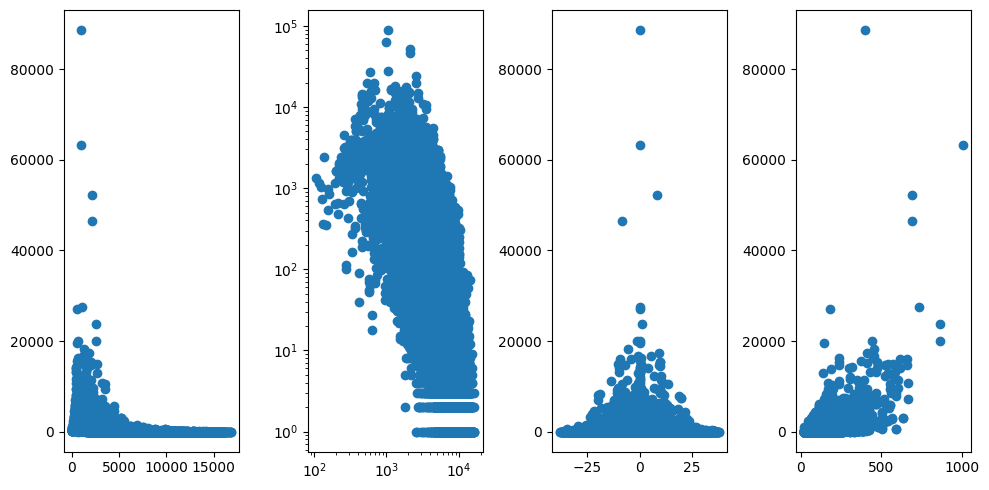

In [51]:
# make plot

fig, axes = plt.subplots(1,4, figsize = (10, 5))

# distance
axes[0].scatter(
    x = msoa_od.distance,
    y = msoa_od.Number,
#    c = msoa_od.is_outbound
)

axes[1].scatter(
    x = msoa_od.distance,
    y = msoa_od.Number,
#    c = msoa_od.is_outbound
)


# take a double log scale for the second one
axes[1].set_xscale('log')
axes[1].set_yscale('log')

# height difference
axes[2].scatter(
    x = msoa_od.height_diff,
    y = msoa_od.Number,
#    c = msoa_od.is_outbound
)

# total ports
axes[3].scatter(
    x = np.sqrt(msoa_od.start_total_ports * msoa_od.end_total_ports),
    y = msoa_od.Number,
#    c = msoa_od.is_outbound
)

plt.tight_layout()
plt.show()

In [52]:
msoa_od_diff = msoa_od[msoa_od.start_MSOA11CD != msoa_od.end_MSOA11CD].copy()

In [53]:
# check the power law behind distance

msoa_od_diff2 = msoa_od_diff[msoa_od_diff.Number != 0].copy()

# get log for distance and trips
msoa_od_diff2['distance_log'] = np.log(msoa_od_diff2.distance)
msoa_od_diff2['number_log'] = np.log(msoa_od_diff2.Number)

log_model = sm.OLS(endog = msoa_od_diff2['number_log'], exog = sm.add_constant(msoa_od_diff2['distance_log'])).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             number_log   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                 2.839e+04
Date:                Sat, 13 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:34:53   Log-Likelihood:                -39435.
No. Observations:               22123   AIC:                         7.887e+04
Df Residuals:                   22121   BIC:                         7.889e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           26.0118      0.133    196.211      0.000      25.752      26.272
distance_log    -2.6250      0.016   -168.492      0.000      -2.656      -2.594
==============================================================================
Omnibus:                        9.986   Durbin-Watson:                   1.095
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.970
Skew:                           0.051   Prob(JB):                      0.00684
Kurtosis:                       3.017   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Correlation Matrix')

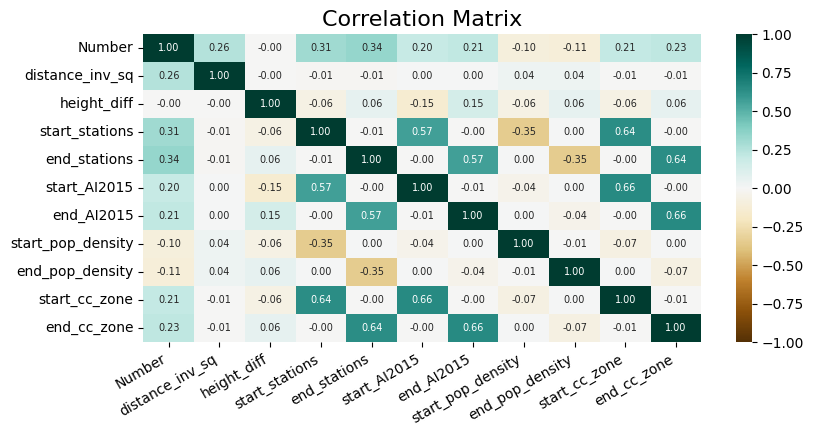

In [54]:
# calculate inverse squared value
msoa_od_diff['distance_inv_sq'] = msoa_od_diff.distance.astype('float') ** (-2) * 1000000

# check multi-colinearity
df2 = msoa_od_diff[['Number', 'distance_inv_sq', 'height_diff', 'start_stations', 'end_stations', 'start_AI2015', 'end_AI2015', 'start_pop_density', 'end_pop_density', 'start_cc_zone', 'end_cc_zone']].copy()
plt.figure(figsize = (9, 4))
heatmap = sns.heatmap(df2.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'BrBG', fmt = '.2f', annot_kws = {'fontsize': 7})
# plt.rcParams["axes.grid"] = False
# f = plt.figure(figsize=(10, 8))
# plt.matshow(df.corr(), fignum=f.number, cmap = 'Blues')
plt.xticks(fontsize = 10, rotation=30, ha = 'right') # rotation of xticks
plt.yticks(fontsize = 10)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [55]:
# using VIF on the dataset
df2_predictors_selected_VIF = drop_column_using_vif_(df2.drop('Number', axis=1))

# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df2_predictors_selected_VIF.columns)

The columns remaining after VIF selection are:
Index(['distance_inv_sq', 'height_diff', 'start_stations', 'end_stations',
       'start_AI2015', 'end_AI2015', 'start_pop_density', 'end_pop_density',
       'start_cc_zone', 'end_cc_zone'],
      dtype='object')


In [56]:
# run linear regression

# set dependent variables
x = df2_predictors_selected_VIF
y = df2.Number

model2 = sm.OLS(endog = y, exog = sm.add_constant(x)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Number   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     1007.
Date:                Sat, 13 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:34:55   Log-Likelihood:            -2.0702e+05
No. Observations:               25440   AIC:                         4.141e+05
Df Residuals:                   25429   BIC:                         4.141e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -482.8715     30.011    -16.090      0.000    -541.694    -424.049
distance_inv_sq     817.9024     16.343     50.046      0.000     785.869     849.936
height_diff          -0.4716      0.422     -1.119      0.263      -1.298       0.355
start_stations       61.4233      1.621     37.884      0.000      58.245      64.601
end_stations         66.8177      1.621     41.211      0.000      63.640      69.996
start_AI2015          1.0362      0.353      2.933      0.003       0.344       1.729
end_AI2015            1.0950      0.353      3.100      0.002       0.403       1.787
start_pop_density    -0.0009      0.001     -0.831      0.406      -0.003       0.001
end_pop_density      -0.0020      0.001     -1.866      0.062      -0.004       0.000
start_cc_zone        21.5298     23.612      0.912      0.362     -24.750      67.810
end_cc_zone          22.7766     23.612      0.965      0.335     -23.503      69.057
==============================================================================
Omnibus:                    54469.275   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        738792824.550
Skew:                          18.524   Prob(JB):                         0.00
Kurtosis:                     837.027   Cond. No.                     1.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
# go back to the original OD pairs
od_df_merged = od_df.join(msoa_pop.add_prefix('start_'), on = 'start_MSOA11CD').join(msoa_pop.add_prefix('end_'), on = 'end_MSOA11CD')

In [58]:
# remove round trips
od_df_merged = od_df_merged[od_df_merged.start_id != od_df_merged.end_id].copy()

In [59]:
# calculate inverted squared distance
od_df_merged['distance_inv_sq'] = od_df_merged.distance ** (-2) * 1000000

In [60]:
od_df_merged.columns

Index(['start_id', 'end_id', 'Bike model', 'Number', 'start_name',
       'start_ports', 'start_location', 'start_zone', 'start_height',
       'start_LSOA11CD', 'start_LSOA11NM', 'start_MSOA11CD', 'start_MSOA11NM',
       'start_cc_zone', 'start_geometry', 'start_ptal_id', 'start_AI2015',
       'end_name', 'end_ports', 'end_location', 'end_zone', 'end_height',
       'end_LSOA11CD', 'end_LSOA11NM', 'end_MSOA11CD', 'end_MSOA11NM',
       'end_cc_zone', 'end_geometry', 'end_ptal_id', 'end_AI2015', 'distance',
       'height_diff', 'start_population', 'start_msoa_area',
       'start_pop_density', 'end_population', 'end_msoa_area',
       'end_pop_density', 'distance_inv_sq'],
      dtype='object')

In [61]:
columns = ['Number', 'distance_inv_sq', 'start_pop_density', 'end_pop_density', 'start_AI2015', 'end_AI2015', 'height_diff', 'start_cc_zone', 'end_cc_zone']

od_df_reg = od_df_merged[columns].copy()

Text(0.5, 1.0, 'Correlation Matrix')

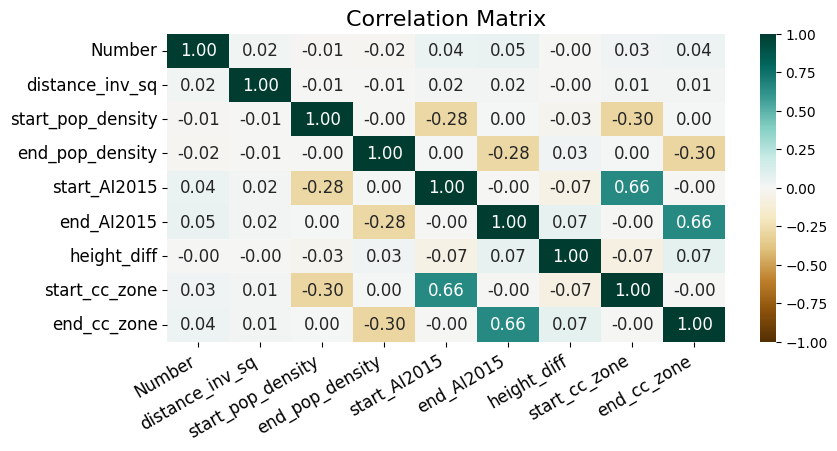

In [62]:
# check multi-colinearity
plt.figure(figsize = (9, 4))
heatmap = sns.heatmap(od_df_reg.corr(), annot = True, vmin = -1, vmax = 1, cmap = 'BrBG', fmt = '.2f', annot_kws = {'fontsize': 12})
# plt.rcParams["axes.grid"] = False
# f = plt.figure(figsize=(10, 8))
# plt.matshow(df.corr(), fignum=f.number, cmap = 'Blues')
plt.xticks(fontsize = 12, rotation=30, ha = 'right') # rotation of xticks
plt.yticks(fontsize = 12)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [63]:
# run linear regression

# set dependent variables
x = od_df_reg.drop(columns = 'Number')
y = od_df_reg.Number

model3 = sm.OLS(endog = y, exog = sm.add_constant(x)).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Number   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     702.3
Date:                Sat, 13 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:35:01   Log-Likelihood:            -6.0043e+06
No. Observations:             1278400   AIC:                         1.201e+07
Df Residuals:                 1278391   BIC:                         1.201e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.3132      0.108     30.783      0.000       3.102       3.524
distance_inv_sq       0.0420      0.002     20.002      0.000       0.038       0.046
start_pop_density  5.068e-06    4.1e-06      1.235      0.217   -2.97e-06    1.31e-05
end_pop_density   -2.726e-05    4.1e-06     -6.643      0.000   -3.53e-05   -1.92e-05
start_AI2015          0.0341      0.001     33.462      0.000       0.032       0.036
end_AI2015            0.0379      0.001     37.136      0.000       0.036       0.040
height_diff          -0.0096      0.002     -5.284      0.000      -0.013      -0.006
start_cc_zone        -0.0170      0.067     -0.256      0.798      -0.148       0.114
end_cc_zone           0.3229      0.067      4.848      0.000       0.192       0.453
==============================================================================
Omnibus:                  2983710.597   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93595066587.517
Skew:                          22.694   Prob(JB):                         0.00
Kurtosis:                    1327.781   Cond. No.                     9.38e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""